# Teorijski uvod

**Amazon Employee Access Challenge** je problem sa dataset platforme Kaggle u kojem je cilj da se, na osnovu istorijskih podataka o zahtevima zaposlenih za pristup određenim resursima, predvidi da li će novi zahtev biti **odobren (1)** ili **odbijen (0)**.
Zaposleni često traže pristup različitim aplikacijama, najbolje bi bilo obezbediti im pristup samo onim aplikacijama koje će im povećati produktivnost na poslu jer:  
- pogrešno odobravanje resursa može dovesti do sigurnosnih propusta ili do odugovlačenja umesto završavanja posla 
- pogrešno odbijanje može smanjiti produktivnost zaposlenih.  

Zbog velikog broja zahteva, ručna evaluacija nije skalabilna. Zato se koriste **algoritmi mašinskog učenja** koji na osnovu prethodnih primera uče obrasce i pomažu u automatskom odlučivanju.  

---

## Dataset 
- Svaki red u podacima dataset-a predstavlja jedan zahtev za pristup
- Dataset sadrži 32.769 redova (opservacija (redova)  
- Kolone sadrže podatke vezane za:  
  - **zaposlenog** (`ROLE_ROLLUP_1`, `ROLE_ROLLUP_2`, `ROLE_DEPTNAME`, `ROLE_TITLE`, `ROLE_FAMILY_DESC`,`ROLE_FAMILY`, `ROLE_CODE`),  
  - **resurs** (`RESOURCE`),  
  - **menadžera** (`MGR_ID`),
  - **predviđanje** (`ACTION`)

> Napomena: Sve promenljive su predstavljene kao **ID-evi**, bez semantičkog značenja. To je Amazon uradio zbog privatnosti podataka (na primer, svako pojavljivanje za `ROLE_TITLE` koje je `project_manager` će biti zamenjeno odgovarajućim ID-em `176508`)

---

## Cilj istraživanja
Ovaj zadatak spada u problem **binarne klasifikacije**: na osnovu atributa zahteva treba predvideti ishod koji ima 2 mogučnosti (odobrenje/odbijanje). Potrebno je napraviti što bolji model mašinskog učenja, odnosno, model koji ima što manju grešku pri predviđanju. Osim toga, možemo i da pokušamo da dođemo do nekih korisnih zakonitosti u podacima (npr. najkorisnije kolone za predviđanje toga da li se isplati dozvoliti zaposlenom pristup određenom resursu, ili kombinacije atributa koje se često pojavljuju zajedno).

Koraci pravljenja modela za predviđanje da li se isplati omogućiti zaposlenom pristup određenom resursu ili ne su:  
1.   Priprema podatke (uklanjanje bespotrebnih kolona, smanjenje dimenzionalnosti problema, ukloniti retkih vrednosti/outlier-a, encoding podataka, kreiranje, podela na trening i testing set podataka, stratifikacija podataka, kreiranje uzoraka, normalizacija (u nasem slucaj bez normalizacije))
2. Izgraditi modele (Decision Tree, Random Forest, Cat Boost, Neural Network, ansambl metode)
3. Evaluirati modele korišćenjem odgovarajućih mera (Accuracy, Precision, Recall, F1, ROC AUC)

- Pre nego što krenemo, potrebno je da import-ujemo sve potrebne Python biblioteke. Koristićemo `pandas` kako bismo mogli da koristimo njegov `DataFrame` tip podataka, `sklearn` zbog njegovih modela mašinskog učenja koje ćemo koristiti, kao i zbog encode-iranja, i `matplotlib` za vizuelizaciju podataka
- Takođe, koristićemo i pomoćne Python fajlove koje smo mi napravili:

1. `preprocessing` - sadrži metode za pripremu podataka - uklanjanje kolona, outlier redova i slično
2. `viewing` - sadrži metode za ispisivanje informacija o dataset-u kao što su broj pojavljivanja za konkretne vrednosti po kolonama na ekranu
3. `models` - sadrži metodu za pokretanje modela, kao i evaluaciju svih potrebnih metrika
4. `evaluation` - sadrži metode za izračunavanje i ispisivanje metrika ocenjivanja modela mašinskog učenja kao što su AOC_RUC i confusion matrix
5. `config` - sadrži podatke koje bi trebalo da budu korišćene u svim fajlovima zbog konzistentnosti (random_state)

In [75]:
import pandas as pd
import sklearn
import matplotlib
import models
import preprocessing as prep
import viewing as view
import config

Kod pomoćnog fajla `config`:

In [47]:
random_state = 42

Atribut random_state se koristi u svim fajlovima kao seed kako bismo dobili konzistentne (iste) rezultate 
svaki put kada pokrenemo model sa istim parametrima 2 ili više puta, umesto da potencijalno dobijemo različite rezultate
zbog RNG-ja (RNG - random number generation).

Kod pomoćnog fajla `preprocessing`:

In [ ]:
import pandas as pd
import os
import config
from sklearn.model_selection import train_test_split


def create_sample(sample_size, csv_location, new_sample_name):
    df = pd.read_csv(csv_location)
    df = df.sample(n=sample_size, random_state=config.random_state)

    # index=False jer necemo pandas dataframe-ovu index kolonu
    # snimi samo ako fajl ne postoji
    if not os.path.exists(new_sample_name):
        df.to_csv(new_sample_name, index=False)
        print(f"File {new_sample_name} saved successfully")
    else:
        print(f"File {new_sample_name} already exists.")


def save_file(dataset_to_save, dataset_saving_location, override):
    if os.path.exists(dataset_saving_location) and not override:
        print(f"File {dataset_saving_location} already exists.")
        return

    dataset_to_save.to_csv(dataset_saving_location, index=False)
    print(f"File {dataset_saving_location} saved successfully")


def remove_outlier_rows(df, column_name, most_common_values_to_preserve):
    most_common_values_to_preserve = df[column_name].value_counts().nlargest(most_common_values_to_preserve).index
    df_new = df[df[column_name].isin(most_common_values_to_preserve)]
    print(f"Rows removed: {len(df)-len(df_new)} ({round(((len(df)-len(df_new))/len(df))*100, 4)}% of rows)")
    return df_new


def remove_columns(df, columns_to_remove):
    # normalizovanje kolona, da ne bude bitno da li je uneto malim ili velikim slovima
    cols_to_remove_lower = [c.lower() for c in columns_to_remove]
    cols_to_keep = [col for col in df.columns if col.lower() not in cols_to_remove_lower]
    return df[cols_to_keep]


def stratified_split(df, target="target", test_size=0.2):
    x = df.drop(columns=[target])
    y = df[target]
    x_train, x_test, y_train, y_test = \
        train_test_split(x, y, test_size=test_size, stratify=y, random_state=config.random_state)
    return x_train, x_test, y_train, y_test

##### Po nazivu metode se vidi čemu ta metoda služi, ali možda nije skroz očigledno na koji način to radi. 
- Metoda `remove_outlier_rows` za prosleđeni DataFrame, odnosno df, će za prosleđen naziv kolone (npr. `ROLE_CODE`) da izbaci sve redove koji imaju vrednost koja se ne nalazi u `most_common_values_to_preserve` najčešće pojavljivanih vrednosti za tu kolonu (npr. ako se "zelena" pojavljuje 8 puta, "crvena" 5 puta, a "plava" 3 puta, a `most_common_values_to_preserve`=2, onda će se izbaciti svi redovi u kojima je vrednost u koloni `ROLE_CODE`="plava" jer je to vrednost koja se ne nalazi u 2 najčešće pojavljivane vrednosti za tu kolonu).
- Metoda `stratified_split` će podeliti podatke u trening i testing set. **"Stratified"** znači da se sve klase izlazne promenljive pojavljuju u istim proporcijama i u trening i u testing set-u podataka, čime se izbegava da neki modeli drugačije gledaju greške klasama jer se ne pojavljuju jednako često. `x_train` je trening set koji sadrži sve promenljive osim one koja se predviđa.  `x_test` je testing set koji sadrži sve promenljive osim one koja se predviđa. `y_train` sadrži samo onu promenljivu koja se predviđa za trening set.  `y_test` sadrži samo onu promenljivu koja se predviđa za testing set.

Kod pomoćnog fajla `viewing`:

In [96]:
import pandas as pd


def print_columns(df):
    print("Column names:", list(df.columns))
    print(f"Total columns for the dataset: {len(list(df.columns))}\n")


def print_rows(df, n_rows=0):
    print(f"Total rows for the dataset: {len(df)}")

    if n_rows == 0:
        return

    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)

    print(df.head(n_rows))

    pd.reset_option("display.max_columns")
    pd.reset_option("display.width")


def print_missing_values(df):
    missing_rows_per_column = df.isnull().sum()
    total_missing_values = df.isnull().sum().sum()
    rows_with_missing_values = df.isnull().any(axis=1).sum()

    print(f"Missing rows per columns\n: {missing_rows_per_column}")
    print(f"Total missing values: {total_missing_values}")
    print(f"Rows with missing values: {rows_with_missing_values}")


def print_value_frequencies(df, normalize=True, top_n=5):
    for col in df.columns:
        print_column_value_frequencies(df, col, normalize, top_n)


def print_column_value_frequencies(df, col, normalize=True, top_n=5):
    print("----------------------------")
    print(f"Column: {col}")
    print("----------------------------")
    value_counts = df[col].value_counts(normalize=normalize)
    print(value_counts.head(top_n))
    print(f"... total unique values: {df[col].nunique()}")


- Metoda `print_value_frequencies` za prosleđeni DataFrame, odnosno df, ispisuje u konzoli za sve kolone njihov naziv i vrednosti `top_n` najčešćih vrednosti, a pored toga procenat redova koji imaju tu vrednost. Osim toga, ispi[e i ukupan broj različitivh vrednosti po koloni. To ume da bude dosta korisno za pronalaženje kolona koje imaju jako mali ili jako veliki broj mogućih vrednosti.
- Metoda `print_column_value_frequencies` radi istu stvar, ali samo za kolonu koja ima naziv `col` umesto za sve kolone u DataFrame-u.

Kod pomoćnog fajla `models`:

In [67]:
import evaluate
import re
import time


def run(models, x_train, x_test, y_train, y_test):
    for model in models:
        print(f"Machine learning algorithm model: {human_readable_model_name(model)}")
        start = time.time()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        print(f"{human_readable_model_name(model)} finished, ⏱ Duration: {time.time() - start:.2f} seconds")
        evaluate.all_metrics(model, x_train, x_test, y_test, y_pred)


def human_readable_model_name(model):
    return re.sub(r'(?<!^)(?=[A-Z])', ' ', type(model).__name__.replace("Classifier", "")
                                                               .replace("Regressor", ""))\
                                                               .strip()

- Metoda `run` pokreće sve prosleđene modele i ispiše rezultate evaluacije modela. Osim toga, ispisaće naziv algoritma mašinskog učenja 
koji se koristi, kao i koliko vremena mu je ukupno bilo potrebno da završi.
- `cross-validation` način evaluacije modela nije korišćen jer se nakon njegove upotrebe pokazalo da ne daje bolje rezultate od običnog trening i testing split-a, a i više joj vremena treba kako bi se izvršila.

Kod pomoćnog fajla `evaulate`:

In [3]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix as sk_confusion_matrix,
    roc_auc_score
)


def all_metrics(model, x_train, x_test, y_test, y_pred):
    classification_metrics(y_test, y_pred)
    confusion_matrix(y_test, y_pred)
    roc_auc(model, x_test, y_test)
    feature_importances(model, x_train)


def classification_metrics(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", pos_label=1, zero_division=0)
    tn, fp, fn, tp = sk_confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"Specificity : {specificity:.4f}")


def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y_test, y_pred)
    print("\nConfusion matrix [[TN, FP], [FN, TP]]:")
    print(cm)


def roc_auc(model, x_test, y_test):
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test)[:, 1]  # uzima verovatnoću za pripadanje klasi 1 za svaki red u test set-u
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC  : {auc:.4f}")


def feature_importances(model, x_train, n_feature_importances=15):
    if hasattr(model, "feature_importances_"):
        feat_imp = pd.Series(model.feature_importances_, index=x_train.columns)\
                     .sort_values(ascending=False).head(n_feature_importances)
        print(f"\nTop {n_feature_importances} feature importances:")
        print(feat_imp.to_string())


- Metoda `feature_importances` prikazuje `n_feature_importances` najkorisnijih kolona za donošenje odluke o predviđanje
u modelima koji podržavaju taj atribut (stabla i boosting algoritmi).
- Metoda `roc_auc` prikazuje verovatnoću da će model dodeliti veću verovatnoću pripadanju pozivinoj klasi 
nasumično izabranom pozitivnom primeru nego nasumično izabranom negativnom primeru.

Ako bismo imali problem sa performansama modela (previše vremena potrebno kako bi se evaluirao model), mogli bismo da koristimo metodu `create_sample` koja bira nasumično odabrani broj redova i napravi i sačuva `.csv` fajl, međutim, to nama nije bilo potrebno za dati dataset koji ima oko 32.000 redova i 9 kolona.

In [91]:
new_df_name = "test_small_2800.csv"
prep.create_sample(2800, "train.csv", new_df_name)
new_df = pd.read_csv(new_df_name)

File test_small_2800.csv saved successfully


Kod ispod će učitati .csv fajl u pandas DataFrame, a zatim će se ispisati sve kolone, broj kolona, izbaciće se kolona `ROLE_CODE` jer sadrži redundantne informacije koje se već nalaze u koloni `ROLE_TITLE`, ispisaće se prvih 15 redova dataset-a, a zatim informacije o nedostajućim vrednostima dataset-a. U našem dataset-u nema nedostajućih vrednosti, što je odlično, jer to znači da ne moramo da razmišljamo o načinima na koje bismo pokušali da rešimo taj problem.

In [101]:
train = pd.read_csv("train.csv")
view.print_columns(train)
train = prep.remove_columns(train, ["ROLE_CODE"])
view.print_columns(train)
view.print_rows(train, 15)
view.print_missing_values(train)

Column names: ['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']
Total columns for the dataset: 10

Column names: ['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY']
Total columns for the dataset: 9

Total rows for the dataset: 32769
    ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0        1     39353   85475         117961         118300         123472   
1        1     17183    1540         117961         118343         123125   
2        1     36724   14457         118219         118220         117884   
3        1     36135    5396         117961         118343         119993   
4        1     42680    5905         117929         117930         119569   
5        0     45333   14561         117951         117952         118008   
6        1     25993   17227         117961        

Kod ispod prikazuje za svaku kolonu koliko često se pojavljuju najčešće pojavljivane vrednosti, levo je vrednost, a desno verovatnoća da će se pojaviti, odnosno % redova u kojima je vrednost u toj koloni baš ta. Nije prosleđen parametar za to koliko najčešćih vrednosti želimo da se prikaže, tako da će se prikazati 5 najčešćih jer je default (podrazumevana) vrednost tog parametra 5. Takođe, prikazaće se i ukupan broj različitih vrednosti za tu kolonu.

U našem dataset-u, **sve kolone (atributi) su kategorijske**, odnosno imaju ograničen broj mogućih vrednosti. To što su kategorijske, a ne kontinualne, takođe znači da se ne mogu sagledati kao brojke, odnosno, ne mogu se porediti na numerički način (npr. veća ili manja vrednost ništa ne znači kod kategorijskih promenljivih). Možemo primetiti da je **izlazna promenljiva ACTION poprilično nebalansirana** - kod oko 94% opservacija je dozvoljen pristup resursu, a u oko 6% opservacija nije. Ovaj problem ćemo kasnije **rešiti stratifikacijom**.

In [106]:
view.print_value_frequencies(train)

----------------------------
Column: ACTION
----------------------------
ACTION
1    0.94211
0    0.05789
Name: proportion, dtype: float64
... total unique values: 2
----------------------------
Column: RESOURCE
----------------------------
RESOURCE
4675     0.025603
79092    0.014770
75078    0.012481
25993    0.012481
3853     0.012329
Name: proportion, dtype: float64
... total unique values: 7518
----------------------------
Column: MGR_ID
----------------------------
MGR_ID
770     0.004639
2270    0.003021
2594    0.002502
1350    0.002167
2014    0.002045
Name: proportion, dtype: float64
... total unique values: 4243
----------------------------
Column: ROLE_ROLLUP_1
----------------------------
ROLE_ROLLUP_1
117961    0.653270
117902    0.022643
91261     0.022003
118315    0.015197
118212    0.012207
Name: proportion, dtype: float64
... total unique values: 128
----------------------------
Column: ROLE_ROLLUP_2
----------------------------
ROLE_ROLLUP_2
118300    0.135006
11834

S obzirom na to da modeli imaju problema sa učenjem na osnovu vrednosti koje se pojavljuju samo jedanput
ili jako mali broj puta, jer će se samo zbuniti (šum) jer nemaju dovoljno podataka za takve opservacije kako bi mogli da uoče obrasce,
mi ćemo taj problem rešiti tako što ćemo izbaciti outlier-e. Za to ćemo iskoristiti pomoćnu metodu `remove_outlier_rows` koju smo sami napravili i objasnili. Nakon testiranja modela malo kasnije, došli smo do zaključka da je najbolje sačuvati ovaj broj vrednosti.

**Izbacili smo 0.2319% redova zbog outlier-a `ROLE_TITLE` kolone, a zatim 12.0362% redova zbog outlier-a ROLE_FAMILY_DESC kolone**. To možda naizgled zvuči kao veliki broj redova, i jeste, preko 4.000 od 32.000, ali se isplatilo jer su modeli bolje predviđali nakon izbacivanja tih outlier-a, što i ima smisla, jer je broj jedinstvenih vrednosti za kolonu `ROLE_FAMILY_DESC` spao sa 2358-700=1658, što bi značilo da su se ove vrednosti pojavljivale jedanput, dvaput, ili možda samo triput. Međutim, kada smo pokušali da uklonimo više od 4000 redova, tada je model postao lošiji, verovatno jer je ipak mogao da dođe do korisnih zaključaka čak i kada se ta vrednost pojavljuje samo 4 puta u 32.000 opservacija.

In [112]:
view.print_column_value_frequencies(train, "ROLE_TITLE")
train = prep.remove_outlier_rows(train, "ROLE_TITLE", 290)
view.print_column_value_frequencies(train, "ROLE_TITLE")
view.print_column_value_frequencies(train, "ROLE_FAMILY_DESC")
train = prep.remove_outlier_rows(train, "ROLE_FAMILY_DESC", 700)
view.print_column_value_frequencies(train, "ROLE_FAMILY_DESC")

----------------------------
Column: ROLE_TITLE
----------------------------
ROLE_TITLE
118321    0.141872
117905    0.109341
118784    0.054075
117879    0.038329
118568    0.031829
Name: proportion, dtype: float64
... total unique values: 343
Rows removed: 76 (0.2319% of rows)
----------------------------
Column: ROLE_TITLE
----------------------------
ROLE_TITLE
118321    0.142202
117905    0.109595
118784    0.054201
117879    0.038418
118568    0.031903
Name: proportion, dtype: float64
... total unique values: 290
----------------------------
Column: ROLE_FAMILY_DESC
----------------------------
ROLE_FAMILY_DESC
117906    0.210901
240983    0.038051
117913    0.020494
279443    0.020341
117886    0.016211
Name: proportion, dtype: float64
... total unique values: 2318
Rows removed: 3935 (12.0362% of rows)
----------------------------
Column: ROLE_FAMILY_DESC
----------------------------
ROLE_FAMILY_DESC
117906    0.239759
240983    0.043258
117913    0.023298
279443    0.023124
117

Kodom ispod smo podelili train DataFrame, odnosno naš Amazon dataset, na trening i testing set koristeći našu pomoćnu `stratisfied_split` metodu (to su `x_train` i `x_test` promenljive, dok `y_train` i `y_test` promenljive sadrže samo izlaznu promenljivu, što se i može videti ispod). Nije prosleđen parametar koji određuje odnos trening i testing setova, tako da je metoda iskoristila default (podrazumevanu) vrednost od 0.8 za trening set i 0.2 za testing set.

In [117]:
x_train, x_test, y_train, y_test = prep.stratified_split(train, "ACTION")
print("x_train:\n", x_train)
print("y_train:\n", y_train)
print("x_test:\n", x_test)
print("y_test:\n", y_test)

x_train:
        RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
9221       1020    1571         117961         118300         120410   
1401      38398   18686         117961         118386         128823   
7921      35988    8707         117961         118300          19772   
14213     33147   53150         117902         117903         128935   
21378     13878    6035         117890         117891         117878   
...         ...     ...            ...            ...            ...   
26211     42770    4620         117961         118300         119181   
11431     45726  148795         117935         117936         117878   
8966       6977   91868         117961         118343         123454   
28006     18063    3281         117961         118225         119238   
6468        971    5657         117961         118300         120722   

       ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  
9221       117905            172635       290919  
1401       118321      

Pre svega je potrebno da importujemo potrebne module za modele maŠinskog učenja - 
`RandomForestClassifier`, `DecisionTreeClassifier`, `CatBoostClassifier`, `LGBMClassifier`, a zatim da unesemo parametre i da ih podešavamo tako da ne dođe ni do overfitting-a ni do underfitting-a, da budu što bolje metrike predviđanja modela.

U kodu ispod su prikazana 4 modela mašinskog učenja koja su dala najbolje rezultate za Amazonov dataset. Taj dataset sadrži 9 kategorijskih promenljivih, tako da nije iznenađujuće da će boosting algoritmi i algoritmi sa stablima imati mnogo bolje performanse od modela koji su dizajnirani za rad sa kvantitativnim promenljivama kao što je linearna regresija.

Od 4 iskorišćena modela u kodu ispod, **najbolje se pokazao Random Forest**:
| Metrika    | Vrednost|
|------------|---------|
| Accuracy   | 0.9531  |
| Precision  | 0.9658  |
| Recall     | 0.9850  |
| F1-score   | 0.9753  |
| ROC-AUC    | 0.8808  |

Međutim, manjinsku klasu u našem dataset-u čine negativni, a iz matrice konfuzije možemo videti da je Random Forest predvideo samo 148/(148+189)=0.439=43.9% negativnih ispravo, dok je Light GBM predvideo 218/(218+119)=0.646=64.6% negativnih ispravno, a Decision Tree je čak 247/(247+90)=0.732=73.2% negativnih predvideo ispravno, s tim što je mnogo više grešio kod pozitivnih primera od ostalih modela.

**Zaključak - ne postoji objektivno najbolji model za ovaj dataset, već:**

1. Ako Vam je najvažnije da što ređe date resurs nekome kome nije trebalo da ga date (zbog bezbednosti ili smanjene produktivnosti) - Decision Tree
2. Ako Vam je najvažnije da što ređe ne dozvolite pristup resursu nekome kome jeste trebao (zbog smanjene produktivnosti) - Random Forest
3. Ako su Vam oba jednako važna - Light GBM**

Najvažnija metrika za ovaj dataset je ROC-AUC, jer ostale metrike uglavnom gledaju koliko dobro model klasifikuje pozitivne primere, dok ROC-AUC gleda i negativne.

In [204]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

rf = RandomForestClassifier(
    n_estimators=401,
    max_depth=23,
    n_jobs=-1,  # da koristi sva jezgra kompjutera
    random_state=config.random_state,
    class_weight="balanced_subsample"
)
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=15,
    min_samples_leaf=15,
    class_weight="balanced",
    random_state=config.random_state
)
cb = CatBoostClassifier(
    depth=7,
    learning_rate=0.2,
    iterations=1000,
    l2_leaf_reg=10,
    rsm=0.6,
    auto_class_weights='Balanced',
    random_seed=config.random_state,
    verbose=100  # za ispis iteracije dok se izvrsava
)
lgbm = LGBMClassifier(
    n_estimators=401,
    max_depth=-1,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=config.random_state,
    class_weight="balanced"
)
models.run([rf, dt, cb, lgbm], x_train, x_test, y_train, y_test)

Machine learning algorithm model: Random Forest
Random Forest finished, ⏱ Duration: 5.49 seconds
Accuracy : 0.9531
Precision: 0.9658
Recall   : 0.9850
F1-score : 0.9753

Confusion matrix [[TN, FP], [FN, TP]]:
[[ 148  189]
 [  81 5334]]
ROC-AUC  : 0.8808

Top 15 feature importances:
RESOURCE            0.211164
MGR_ID              0.200423
ROLE_DEPTNAME       0.145591
ROLE_FAMILY_DESC    0.117302
ROLE_ROLLUP_2       0.101965
ROLE_TITLE          0.099863
ROLE_FAMILY         0.067476
ROLE_ROLLUP_1       0.056215
Machine learning algorithm model: Decision Tree
Decision Tree finished, ⏱ Duration: 0.13 seconds
Accuracy : 0.7559
Precision: 0.9785
Recall   : 0.7573
F1-score : 0.8538

Confusion matrix [[TN, FP], [FN, TP]]:
[[ 247   90]
 [1314 4101]]
ROC-AUC  : 0.8098

Top 15 feature importances:
MGR_ID              0.234924
ROLE_DEPTNAME       0.172458
ROLE_FAMILY_DESC    0.136052
RESOURCE            0.128742
ROLE_ROLLUP_2       0.106485
ROLE_TITLE          0.103589
ROLE_FAMILY         0.069451

Pokušaćemo i model Neuronske mreže da iskoristimo, odnosno MLP (multilayer perceptron), međutim, neuronske mreže uvek posmatraju brojeve kao kontinualne promenljive, iako su u našem slučaju ti brojevi (id-jevi) kategorijske promenljive, tako da će neuronska mreža jednostavno predvideti da je svaka opservacija True, jer je to češća klasa, što je najjednostavniji mogući model, i zato ima ROC-AUC ~0.5 (jer nije ubo nijedan negativan) i Recall ~1 (jer je ubo sve pozitivne skoro).

In [180]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(18, 9),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    alpha=1e-4,
    batch_size=256,
    max_iter=200,
    early_stopping=True,  
    n_iter_no_change=15,
    random_state=config.random_state,
    verbose=False
)

models.run([mlp], x_train, x_test, y_train, y_test)

Machine learning algorithm model: M L P
M L P finished, ⏱ Duration: 1.86 seconds
Accuracy : 0.9411
Precision: 0.9414
Recall   : 0.9996
F1-score : 0.9696

Confusion matrix [[TN, FP], [FN, TP]]:
[[   0  337]
 [   2 5413]]
ROC-AUC  : 0.5004


Taj problem smo rešili tako što smo iskoristili **One hot encoding** koji će da svaku kolonu sa kategorijskim vrednostima transformiše u više binarnih kolona (0/1), pri čemu svaka nova kolona predstavlja jednu kategoriju (npr. 1 kolona sa mogućim vrednostima "blue", "green" i "red" bi se pretvorila u 3 kolone "blue", "green" i "red" koje imaju vrednosti 0 ili 1, samo 1 od tih kolona će imati vrednost 1, dok će ostale imati 0).

In [182]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# "Eksplicitno naglasavamo" modelima da tretiraju kolone kao kategorijske string-ove iako su brojevi (id-evi) preko *One hot encoding"-a
cat_cols = list(x_train.columns)
xtr_cat = x_train[cat_cols].astype(str).fillna("(missing)")
xte_cat = x_test[cat_cols].astype(str).fillna("(missing)")

oh = ColumnTransformer(
    transformers=[(
        "oh",
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        cat_cols
    )],
    remainder="drop"
)

X_train_oh = pd.DataFrame(
    oh.fit_transform(xtr_cat),
    columns=oh.named_transformers_["oh"].get_feature_names_out(cat_cols),
    index=x_train.index
)
X_test_oh = pd.DataFrame(
    oh.transform(xte_cat),
    columns=oh.named_transformers_["oh"].get_feature_names_out(cat_cols),
    index=x_test.index
)

Na taj nacin smo dobili model koji, iako ima malo manji ROC-AUC od Random Forest-a (0.8794<0.8808), **MLP je zapravo dosta lošiji za predviđanje 
iz razloga što dosta lošije pogađa negativne primere** (kada nije trebalo dati pristup resursu zaposlenom), iako malo bolje pogađa pozitivne primere (kada jeste trebalo dati pristup resursu zaposlenom). Osim, toga, zbog One hot encoding-a će biti jako puno kolona i sporo će se izvršiti model (preko 1 minut).

In [185]:
models.run([mlp], X_train_oh, X_test_oh, y_train, y_test)

Machine learning algorithm model: M L P
M L P finished, ⏱ Duration: 64.90 seconds
Accuracy : 0.9485
Precision: 0.9568
Recall   : 0.9900
F1-score : 0.9731

Confusion matrix [[TN, FP], [FN, TP]]:
[[  95  242]
 [  54 5361]]
ROC-AUC  : 0.8794


U kodu ispod se prikazuje Kramerova toplotna mapa koja koristi hi-kvadrat statistiku kako bi se izracunala korelacija izmedju
2 kvalitativna (kategorijska) obeležja. `MGR_ID` ima veze sa svim promenljivima, što i ima smisla. To znači da informacije o zaposlenom, kao što su ROLE_FAMILY, imaju dosta veza sa time ko je menadžer, jer se često isti menadžer postavlja zaposlenima na sličnim pozicijama, dok, npr. između `RESOURCE` i `ROLE_FAMILY_DESC` ne postoji jaka veza (korelacija). 

Ovaj deo koda je bio analiza podataka, odnosno pronalaženje zakonitosti u podacima, a ne mašinsko učenje, kao dosad.

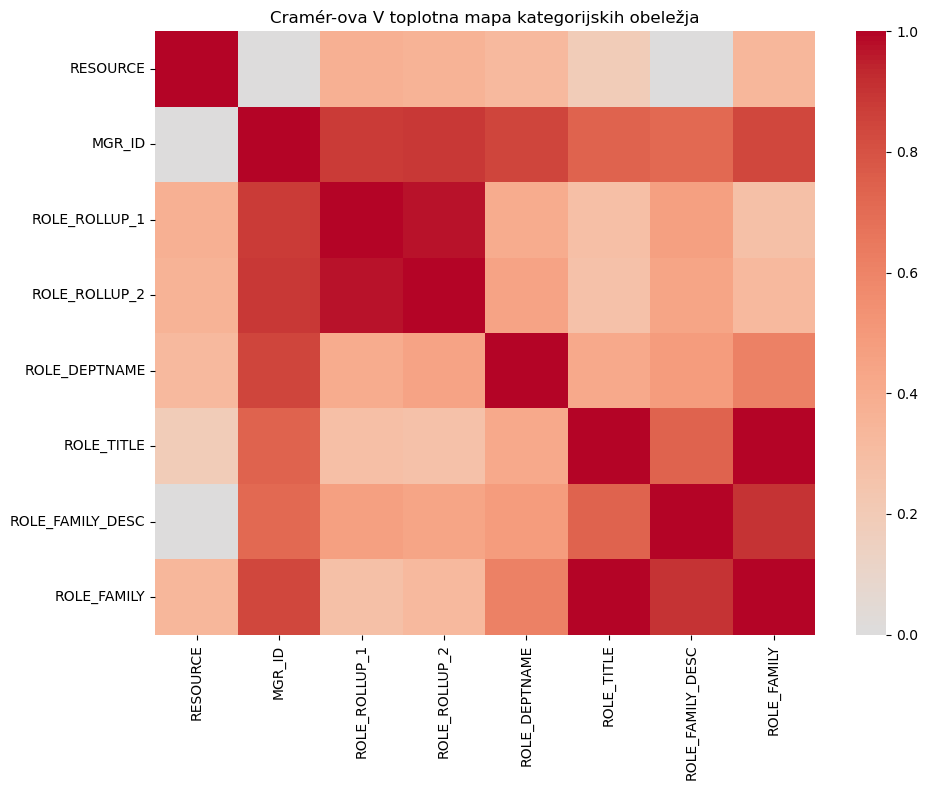

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


cat_cols_all = [c for c in train.columns if c != "ACTION"]
cramers_matrix = pd.DataFrame(index=cat_cols_all, columns=cat_cols_all)

for col1 in cat_cols_all:
    for col2 in cat_cols_all:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0
        else:
            cramers_matrix.loc[col1, col2] = cramers_v(train[col1], train[col2])

cramers_matrix = cramers_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Cramér-ova V toplotna mapa kategorijskih obeležja")
plt.tight_layout()
plt.show()